<a href="https://colab.research.google.com/github/saeedzou/Machine-Unlearning/blob/master/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [2]:
# load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Set the random seed
torch.manual_seed(42)
# define lenet5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
# define a function to train the model
def train(model, trainloader, testloader, criterion, optimizer, num_epochs, device):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        # train
        model.train()
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_acc += (preds == labels.data).float().mean()
        train_loss.append(running_loss / len(trainloader))
        train_acc.append(running_acc / len(trainloader))
        # test
        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        with torch.no_grad():
            for images, labels in tqdm(testloader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs.data, 1)
                running_acc += (preds == labels.data).float().mean()
        test_loss.append(running_loss / len(testloader))
        test_acc.append(running_acc / len(testloader))
        print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'.format(epoch+1, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))
    return train_loss, train_acc, test_loss, test_acc

In [5]:
# define a function for evaluating a single image that returns the logits and the predicted class
def evaluate(model, image, device):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, pred = torch.max(output.data, 1)
    return output, pred

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
# save model weights
torch.save(model.state_dict(), 'initial_weights.pth')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Ground truth label: 5
Logits: tensor([[ 0.0515,  0.0470,  0.0293,  0.0739, -0.1068,  0.0208,  0.0383,  0.0288,
         -0.0428,  0.0473]], device='cuda:0')
Predicted class: tensor([3], device='cuda:0')


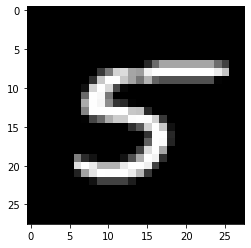

In [7]:
# select a random image from the training set, plot it and evaluate it and show its ground truth label
random_index = np.random.randint(0, len(trainset))
image, label = trainset[random_index]
plt.imshow(image.squeeze(), cmap='gray')
print('Ground truth label: {}'.format(label))
# print the logits and the predicted class
output, pred = evaluate(model, image.unsqueeze(0), device)
print('Logits: {}'.format(output))
print('Predicted class: {}'.format(pred))

In [8]:
train_loss, train_acc, test_loss, test_acc = train(model, trainloader, testloader, criterion, optimizer, 10, device)

100%|██████████| 313/313 [00:02<00:00, 156.23it/s]


Epoch: 1, Train Loss: 0.1965, Train Acc: 0.9385, Test Loss: 0.0672, Test Acc: 0.9778


100%|██████████| 313/313 [00:04<00:00, 67.71it/s]


Epoch: 2, Train Loss: 0.0608, Train Acc: 0.9812, Test Loss: 0.0396, Test Acc: 0.9879


100%|██████████| 313/313 [00:02<00:00, 125.52it/s]


Epoch: 3, Train Loss: 0.0444, Train Acc: 0.9859, Test Loss: 0.0590, Test Acc: 0.9798


100%|██████████| 313/313 [00:01<00:00, 164.06it/s]


Epoch: 4, Train Loss: 0.0345, Train Acc: 0.9894, Test Loss: 0.0385, Test Acc: 0.9892


100%|██████████| 313/313 [00:01<00:00, 160.19it/s]


Epoch: 5, Train Loss: 0.0294, Train Acc: 0.9905, Test Loss: 0.0378, Test Acc: 0.9880


100%|██████████| 313/313 [00:02<00:00, 127.37it/s]


Epoch: 6, Train Loss: 0.0247, Train Acc: 0.9918, Test Loss: 0.0315, Test Acc: 0.9904


100%|██████████| 313/313 [00:01<00:00, 156.59it/s]


Epoch: 7, Train Loss: 0.0212, Train Acc: 0.9931, Test Loss: 0.0363, Test Acc: 0.9891


100%|██████████| 313/313 [00:01<00:00, 157.88it/s]


Epoch: 8, Train Loss: 0.0180, Train Acc: 0.9940, Test Loss: 0.0352, Test Acc: 0.9903


100%|██████████| 313/313 [00:01<00:00, 157.82it/s]


Epoch: 9, Train Loss: 0.0179, Train Acc: 0.9945, Test Loss: 0.0407, Test Acc: 0.9891


100%|██████████| 313/313 [00:02<00:00, 128.75it/s]

Epoch: 10, Train Loss: 0.0150, Train Acc: 0.9954, Test Loss: 0.0370, Test Acc: 0.9900


Ground truth label: 5
Logits: tensor([[-14.0037, -12.0592, -16.3269,  -0.0306, -13.6175,  17.1419, -12.0098,
          -8.6392,  -6.1921,   0.2100]], device='cuda:0')
Predicted class: tensor([5], device='cuda:0')


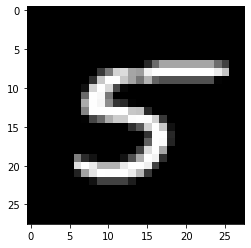

In [11]:
# evaluate the model on the sampled image
plt.imshow(image.squeeze(), cmap='gray')
print('Ground truth label: {}'.format(label))
output, pred = evaluate(model, image.unsqueeze(0), device)
print('Logits: {}'.format(output))
print('Predicted class: {}'.format(pred))

In [10]:
# now remove this example from the training set and retrain the model
trainset_filtered = torch.utils.data.Subset(trainset, [i for i in range(len(trainset)) if i != random_index])
trainloader_filtered = torch.utils.data.DataLoader(trainset_filtered, batch_size=32, shuffle=True)

Ground truth label: 5
Logits: tensor([[ 0.0515,  0.0470,  0.0293,  0.0739, -0.1068,  0.0208,  0.0383,  0.0288,
         -0.0428,  0.0473]], device='cuda:0')
Predicted class: tensor([3], device='cuda:0')


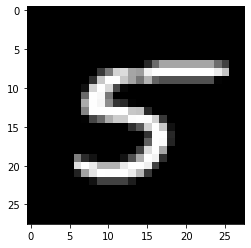

In [12]:
# define a new model
model = LeNet5().to(device)
# load the initial weights
model.load_state_dict(torch.load('initial_weights.pth'))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# evaluate the model on the sampled image
plt.imshow(image.squeeze(), cmap='gray')
print('Ground truth label: {}'.format(label))
output, pred = evaluate(model, image.unsqueeze(0), device)
print('Logits: {}'.format(output))
print('Predicted class: {}'.format(pred))


In [13]:
# train the model
train_loss_filtered, train_acc_filtered, test_loss_filtered, test_acc_filtered = train(model, trainloader_filtered, testloader, criterion, optimizer, 10, device)

100%|██████████| 313/313 [00:02<00:00, 154.34it/s]


Epoch: 1, Train Loss: 0.1911, Train Acc: 0.9403, Test Loss: 0.0720, Test Acc: 0.9754


100%|██████████| 313/313 [00:01<00:00, 159.52it/s]


Epoch: 2, Train Loss: 0.0617, Train Acc: 0.9808, Test Loss: 0.0372, Test Acc: 0.9873


100%|██████████| 313/313 [00:01<00:00, 159.08it/s]


Epoch: 3, Train Loss: 0.0451, Train Acc: 0.9862, Test Loss: 0.0443, Test Acc: 0.9862


100%|██████████| 313/313 [00:01<00:00, 157.22it/s]


Epoch: 4, Train Loss: 0.0355, Train Acc: 0.9891, Test Loss: 0.0423, Test Acc: 0.9864


100%|██████████| 313/313 [00:02<00:00, 154.95it/s]


Epoch: 5, Train Loss: 0.0270, Train Acc: 0.9910, Test Loss: 0.0341, Test Acc: 0.9887


100%|██████████| 313/313 [00:02<00:00, 129.22it/s]


Epoch: 6, Train Loss: 0.0244, Train Acc: 0.9924, Test Loss: 0.0374, Test Acc: 0.9885


100%|██████████| 313/313 [00:01<00:00, 163.73it/s]


Epoch: 7, Train Loss: 0.0200, Train Acc: 0.9936, Test Loss: 0.0319, Test Acc: 0.9905


100%|██████████| 313/313 [00:01<00:00, 159.27it/s]


Epoch: 8, Train Loss: 0.0185, Train Acc: 0.9939, Test Loss: 0.0381, Test Acc: 0.9882


100%|██████████| 313/313 [00:01<00:00, 165.72it/s]


Epoch: 9, Train Loss: 0.0157, Train Acc: 0.9952, Test Loss: 0.0377, Test Acc: 0.9890


100%|██████████| 313/313 [00:01<00:00, 163.05it/s]

Epoch: 10, Train Loss: 0.0150, Train Acc: 0.9949, Test Loss: 0.0311, Test Acc: 0.9908


Ground truth label: 5
Logits: tensor([[-17.8723, -12.6182, -12.6487,  -6.4497, -12.4231,  15.3858, -14.1757,
         -11.3532,  -5.1100,  -2.7184]], device='cuda:0')
Predicted class: tensor([5], device='cuda:0')


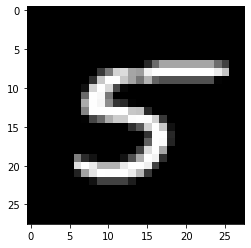

In [14]:
# evaluate the model on the sampled image
plt.imshow(image.squeeze(), cmap='gray')
print('Ground truth label: {}'.format(label))
output, pred = evaluate(model, image.unsqueeze(0), device)
print('Logits: {}'.format(output))
print('Predicted class: {}'.format(pred))